In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('../data/raw/playersData.csv', encoding='utf-8-sig')
df.head()

,Rk,Player,Nation,Pos,Squad,Comp,Age,Born,MP,Starts,...,Att (GK),Thr,Launch%,AvgLen,Opp,Stp,Stp%,#OPA,#OPA/90,AvgDist
0,1,Max Aarons,eng ENG,DF,Bournemouth,eng Premier League,24.0,2000.0,3,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,Max Aarons,eng ENG,"DF,MF",Valencia,es La Liga,24.0,2000.0,4,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,Rodrigo Abajas,es ESP,DF,Valencia,es La Liga,21.0,2003.0,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,James Abankwah,ie IRL,"DF,MF",Udinese,it Serie A,20.0,2004.0,6,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,Keyliane Abdallah,fr FRA,FW,Marseille,fr Ligue 1,18.0,2006.0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
#filtering out players based on the number of 90 minutes played in the season, to avoid null data
df = df[pd.to_numeric(df['90s'], errors='coerce') >= 3].copy()

In [5]:
#Check for the number of unique teams covered
print(len(sorted(df['Squad'].unique())))

96


In [6]:
#Coluns important to derive positional classification data.
counting_cols = [
    'Gls', 'Ast', 'xG', 'xAG', 'PrgC', 'PrgP',
    'Tkl', 'TklW', 'Int', 'Clr', 'Blocks_stats_defense',
    'KP', 'SCA', 'GCA',
    'Sh', 'SoT',
    'Def 3rd', 'Att 3rd',
    'Def 3rd_stats_possession',
    'Att 3rd_stats_possession', 'Att Pen',
    'PrgC_stats_possession',
    'Crs_stats_passing_types',
    'Won',
]

In [7]:
#making sure all the players data is calculated as a per match impact they provide by dividing with 90s
for col in counting_cols:
    if col in df.columns:
        df[col + '_p90'] = pd.to_numeric(df[col], errors='coerce') / pd.to_numeric(df['90s'], errors='coerce')

In [8]:
#Converting Completion percentage as a numeric data field
df['Cmp%'] = pd.to_numeric(df['Cmp%'], errors='coerce')
#Additional data required for players
df['Crs_p90'] = pd.to_numeric(df['Crs'], errors='coerce') / pd.to_numeric(df['90s'], errors='coerce')

In [9]:
df.head()

,Rk,Player,Nation,Pos,Squad,Comp,Age,Born,MP,Starts,...,Sh_p90,SoT_p90,Def 3rd_p90,Att 3rd_p90,Def 3rd_stats_possession_p90,Att 3rd_stats_possession_p90,Att Pen_p90,PrgC_stats_possession_p90,Won_p90,Crs_p90
5,6,Yunis Abdelhamid,ma MAR,DF,Saint-Étienne,fr Ligue 1,36.0,1987.0,16,11,...,0.173913,0.086957,1.304348,0.000000,36.000000,1.217391,0.608696,0.347826,1.652174,0.000000
6,7,Himad Abdelli,dz ALG,"MF,FW",Angers,fr Ligue 1,24.0,1999.0,32,32,...,1.107595,0.253165,0.411392,0.474684,9.272152,18.892405,1.550633,3.386076,0.411392,1.392405
7,8,Mohamed Abdelmoneim,eg EGY,DF,Nice,fr Ligue 1,25.0,1999.0,12,10,...,0.000000,0.000000,1.263158,0.315789,27.368421,4.842105,0.315789,0.631579,3.263158,0.210526
8,9,Ali Abdi,tn TUN,"DF,MF",Nice,fr Ligue 1,30.0,1993.0,25,17,...,1.870968,0.709677,1.161290,0.709677,14.838710,20.322581,3.225806,2.258065,1.419355,3.290323
10,11,Abel,es ESP,DF,Osasuna,es La Liga,23.0,2000.0,35,20,...,0.521739,0.173913,1.217391,0.347826,16.086957,15.521739,0.826087,2.173913,0.869565,3.695652


In [10]:
# Engineered ratio features
df['def_rate_p90']       = df['Tkl_p90'] + df['Int_p90']
df['def3_att3_ratio']    = df['Def 3rd_stats_possession_p90'] / (df['Att 3rd_stats_possession_p90'] + 1)
df['attacking_intent']   = df['Att 3rd_stats_possession_p90'] / (df['Def 3rd_stats_possession_p90'] + 1)
df['goal_contribution']  = df['Gls_p90'] + df['xG_p90']
df['cross_carry_ratio']  = df['Crs_p90'] / (df['PrgC_stats_possession_p90'] + 0.1)
df['prgp_crs_ratio']     = df['PrgP_p90'] / (df['Crs_p90'] + 0.1)   # high = CM, low = Winger

# One-hot encode FBref position codes so the RF knows the player's primary position.
# This is the most powerful signal — a MF,DF player can NEVER be a Fullback,
# and a GK can NEVER be a Striker. Giving the RF this directly eliminates
# cross-boundary errors that pure stat features can't resolve.
pos_dummies = pd.get_dummies(df['Pos'], prefix='pos')
df = pd.concat([df, pos_dummies], axis=1)

print(f"Position codes in dataset : {sorted(df['Pos'].unique())}")
print(f"Position dummy columns    : {[c for c in df.columns if c.startswith('pos_')]}")
print(f"Per-90 stat columns       : {len([c for c in df.columns if c.endswith('_p90')])}")

Position codes in dataset : ['DF', 'DF,FW', 'DF,MF', 'FW', 'FW,DF', 'FW,MF', 'GK', 'MF', 'MF,DF', 'MF,FW']
Position dummy columns    : ['pos_DF', 'pos_DF,FW', 'pos_DF,MF', 'pos_FW', 'pos_FW,DF', 'pos_FW,MF', 'pos_GK', 'pos_MF', 'pos_MF,DF', 'pos_MF,FW']
Per-90 stat columns       : 25


In [11]:
def assign_role(row):
    pos = str(row['Pos'])

    if 'GK' in pos:
        return 'Goalkeeper'

    def g(col):
        try:
            return float(row.get(col, 0) or 0)
        except:
            return 0.0

    tkl      = g('Tkl_p90')
    int_     = g('Int_p90')
    clr      = g('Clr_p90')
    won      = g('Won_p90')
    kp       = g('KP_p90')
    sca      = g('SCA_p90')
    prgc     = g('PrgC_stats_possession_p90')
    prgp     = g('PrgP_p90')
    att3     = g('Att 3rd_stats_possession_p90')
    attpen   = g('Att Pen_p90')
    sh       = g('Sh_p90')
    xg       = g('xG_p90')
    crs      = g('Crs_p90')
    gls      = g('Gls_p90')
    d3_ratio = g('def3_att3_ratio')   # def3_touches / (att3_touches + 1)

    def_act = tkl + int_

    # ── DF: Pure defender — CB or Fullback ──────────────────────────────────
    # Strategy: require explicit Fullback SIGNALS. Without them, default to CB.
    # A typical CB: d3_ratio 10-30, crs < 0.3, att3 < 3
    # A typical FB:  d3_ratio 2-6,  crs > 1.0, att3 > 6
    if pos == 'DF':
        # Strong CB: heavily defensive third, minimal crossing
        if d3_ratio >= 8 and crs < 0.8:          return 'Centre Back'
        # Clear FB: consistent crossing OR heavy att-3rd presence
        if crs >= 1.5 or att3 >= 14:             return 'Fullback'
        # Overlapping/progressive FB: carries ball deep into attack
        if prgc >= 3.5 and att3 >= 7:            return 'Fullback'
        # Ball-playing CB: d3_ratio still defensive despite some forward work
        if d3_ratio >= 4:                         return 'Centre Back'
        # Low d3_ratio (getting forward a lot) + some crossing → FB
        if crs >= 0.8:                            return 'Fullback'
        # Default → Centre Back. Without explicit FB signals a DF-coded
        # player is more likely a CB than a FB.
        return 'Centre Back'

    # ── DF,MF: Primarily defender with midfield duties — FB, CB, or DM ─────
    if pos == 'DF,MF':
        # Attacking fullback: crosses consistently or gets into att 3rd heavily
        if crs >= 1.5 or att3 >= 14:             return 'Fullback'
        # Holding DM listed as DF: high def actions, not pushing forward
        if def_act >= 3.5 and att3 < 8 and kp < 1.5:  return 'Defensive Mid'
        dm = def_act * 1.5
        cb = clr * 2 + won
        fb = prgc * 2 + crs * 2 + att3 * 0.15
        if dm > max(cb, fb) and att3 < 12:       return 'Defensive Mid'
        # d3_ratio check: CB if still predominantly in defensive third
        if d3_ratio >= 5:                         return 'Centre Back'
        return 'Fullback'

    # ── MF,DF: Primarily midfielder with defensive duties — DM or CM ONLY ──
    # NEVER a fullback. Endo, Rice, Partey all fall here.
    if pos == 'MF,DF':
        if def_act >= 2.0:                        return 'Defensive Mid'
        if def_act >= 1.5 and kp < 1.5:          return 'Defensive Mid'
        return 'Central Mid'

    # ── MF: Pure midfielder — DM or CM ─────────────────────────────────────
    if pos == 'MF':
        if def_act >= 3.5 and kp < 1.5 and att3 < 8:  return 'Defensive Mid'
        if def_act >= 2.5 and kp < 1.0:               return 'Defensive Mid'
        return 'Central Mid'

    # ── MF,FW: Primarily midfielder — CM or Winger ─────────────────────────
    # kp ≥ 1.5 → playmaker (KDB, Ødegaard). Check before width signals.
    if pos == 'MF,FW':
        if kp >= 1.5:                             return 'Central Mid'
        if crs >= 2.0:                            return 'Winger'
        w = crs * 3 + prgc * 1.5 + att3 * 0.1
        m = kp  * 3 + prgp * 2.0 + sca  * 0.8
        return 'Winger' if w >= m else 'Central Mid'

    # ── FW,MF: Primarily forward — Winger or Striker ───────────────────────
    if pos == 'FW,MF':
        if crs >= 1.5:                            return 'Winger'
        if xg >= 0.4 and sh >= 1.5:              return 'Striker'
        w = crs * 3 + prgc * 1.5 + att3 * 0.1
        m = kp  * 3 + prgp * 1.5 + sca  * 0.5
        return 'Winger' if w >= m else 'Striker'

    # ── FW: Pure forward — Striker or Winger ───────────────────────────────
    if pos == 'FW':
        if crs >= 1.5:                            return 'Winger'
        if xg >= 0.5 and sh >= 2.0:              return 'Striker'
        if attpen >= 4.0:                         return 'Striker'
        st = attpen * 2 + sh * 1.5 + xg * 3 + gls * 2
        wi = prgc   * 2 + crs * 3  + att3 * 0.08
        return 'Striker' if st >= wi else 'Winger'

    # ── DF,FW / FW,DF: Rare hybrids ─────────────────────────────────────────
    if pos in ('DF,FW', 'FW,DF'):
        if crs >= 1.0:                            return 'Winger'
        return 'Striker'

    return 'Central Mid'

In [12]:
df['role'] = df.apply(assign_role, axis=1)
print(df['role'].value_counts())

role
Centre Back      413
Fullback         375
Central Mid      366
Winger           365
Striker          269
Defensive Mid    256
Goalkeeper       170
Name: count, dtype: int64


In [13]:
feature_cols = [c for c in df.columns if (
    c.endswith('_p90') or
    c.startswith('pos_') or          # position code dummies — key new signal
    c in ['def_rate_p90', 'def3_att3_ratio', 'attacking_intent',
          'goal_contribution', 'cross_carry_ratio', 'prgp_crs_ratio', 'Cmp%']
)]
feature_cols = [c for c in feature_cols if df[c].notna().sum() > 100]

X = df[feature_cols].fillna(0)
y = df['role']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

rf = RandomForestClassifier(n_estimators=500, random_state=42, class_weight='balanced', n_jobs=-1)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))

               precision    recall  f1-score   support

  Central Mid       0.90      0.95      0.92        73
  Centre Back       0.95      1.00      0.98        83
Defensive Mid       0.98      0.88      0.93        51
     Fullback       1.00      0.93      0.97        75
   Goalkeeper       1.00      1.00      1.00        34
      Striker       0.88      0.94      0.91        54
       Winger       0.93      0.90      0.92        73

     accuracy                           0.94       443
    macro avg       0.95      0.94      0.95       443
 weighted avg       0.95      0.94      0.94       443



In [14]:
from sklearn.model_selection import RandomizedSearchCV

# max_depth=10 consistently underperforms on the test set — exclude it
param_dist = {
    'n_estimators':      [400, 500, 700],
    'max_depth':         [None, 20, 30],
    'min_samples_split': [2, 5],
    'min_samples_leaf':  [1, 2],
    'max_features':      ['sqrt', 'log2']
}

search = RandomizedSearchCV(
    RandomForestClassifier(class_weight='balanced', random_state=42),
    param_distributions=param_dist,
    n_iter=20,
    cv=5,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1
)
search.fit(X_train, y_train)

baseline_acc = (y_pred == y_test).mean()
tuned_pred   = search.best_estimator_.predict(X_test)
tuned_acc    = (tuned_pred == y_test).mean()

print(f"Baseline test accuracy : {round(baseline_acc * 100, 2)}%")
print(f"Tuned test accuracy    : {round(tuned_acc * 100, 2)}%")
print(f"Best params            : {search.best_params_}")

# Use whichever model is better on the test set
if tuned_acc > baseline_acc:
    rf     = search.best_estimator_
    y_pred = tuned_pred
    print("\nUsing tuned model.")
else:
    print("\nBaseline model is better — keeping it.")

print(classification_report(y_test, y_pred))

Baseline test accuracy : 94.36%
Tuned test accuracy    : 94.81%
Best params            : {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None}

Using tuned model.
               precision    recall  f1-score   support

  Central Mid       0.91      0.93      0.92        73
  Centre Back       0.97      1.00      0.98        83
Defensive Mid       0.98      0.88      0.93        51
     Fullback       1.00      0.95      0.97        75
   Goalkeeper       1.00      1.00      1.00        34
      Striker       0.88      0.96      0.92        54
       Winger       0.93      0.92      0.92        73

     accuracy                           0.95       443
    macro avg       0.95      0.95      0.95       443
 weighted avg       0.95      0.95      0.95       443



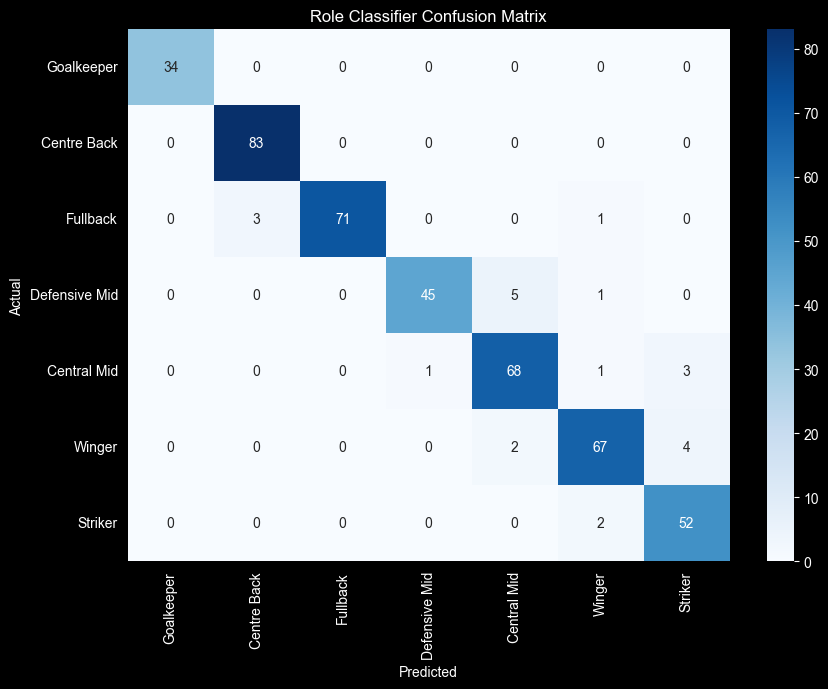

In [15]:
roles = ['Goalkeeper', 'Centre Back', 'Fullback', 'Defensive Mid',
         'Central Mid', 'Winger', 'Striker']

cm = confusion_matrix(y_test, y_pred, labels=roles)
plt.figure(figsize=(9, 7))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=roles, yticklabels=roles, cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Role Classifier Confusion Matrix')
plt.tight_layout()
plt.show()

In [16]:
known = [
    # Defenders
    'Virgil van Dijk',          # CB       DF
    'Trent Alexander-Arnold',   # Fullback DF

    # Midfielders
    'Wataru Endo',              # DM       MF,DF  ← was misclassified as Fullback
    'Kevin De Bruyne',          # CM       MF,FW  ← was misclassified as Winger
    'Martin Ødegaard',          # CM       MF,FW

    # Forwards
    'Mohamed Salah',            # Winger   FW
    'Bukayo Saka',              # Winger   FW,MF
    'Rodrygo',                  # Winger   FW,MF
    'Erling Haaland',           # Striker  FW
    'Harry Kane',               # Striker  FW
    'Kylian Mbappé',            # Striker  FW
]

check = df[df['Player'].isin(known)][['Player', 'Squad', 'Pos', 'role']]
print(check.to_string())


                      Player            Squad    Pos           role
83    Trent Alexander-Arnold        Liverpool     DF       Fullback
678          Kevin De Bruyne  Manchester City  MF,FW    Central Mid
844              Wataru Endo        Liverpool  MF,DF  Defensive Mid
1109          Erling Haaland  Manchester City     FW        Striker
1317              Harry Kane    Bayern Munich     FW        Striker
1691           Kylian Mbappé      Real Madrid     FW        Striker
2242                 Rodrygo      Real Madrid  FW,MF         Winger
2299             Bukayo Saka          Arsenal  FW,MF         Winger
2304           Mohamed Salah        Liverpool     FW         Winger
2670         Virgil van Dijk        Liverpool     DF    Centre Back
2851         Martin Ødegaard          Arsenal     MF    Central Mid


In [17]:
import joblib
import os

In [18]:
os.makedirs('../models', exist_ok=True)

In [19]:
joblib.dump(rf, '../models/role_classifier.joblib')
print("Model saved!")

Model saved!


In [20]:
import json

In [21]:
df['predicted_role'] = rf.predict(df[feature_cols].fillna(0))

In [ ]:
import numpy as np

def pct_global(df, stat):
    """
    Rank EVERY player against all 2,214 players on this stat.
    Range: ~5 (bottom) → ~95 (top).
    ALL THREE dimensions use the same global scale so cross-role
    comparisons in the simulation are meaningful:
      CDM defending vs CB defending   → both ranked globally → directly comparable
      CM passing vs Striker attacking → both globally ranked → comparable
    """
    vals = pd.to_numeric(df[stat], errors='coerce').fillna(0)
    return vals.rank(pct=True) * 90 + 5

# ── Derived stats not in the per-90 block ────────────────────────────────────
df['finishing_eff'] = (
    pd.to_numeric(df['Gls'], errors='coerce') /
    pd.to_numeric(df['xG'],  errors='coerce').clip(lower=0.5)
).clip(0.2, 2.0).fillna(1.0)

df['TklW_p90'] = (
    pd.to_numeric(df['TklW'], errors='coerce') /
    pd.to_numeric(df['90s'],  errors='coerce')
)

# ── ATTACKING — global ────────────────────────────────────────────────────────
# Strikers and Wingers dominate (85-95). CBs cluster near 50.
df['attacking'] = (
    pct_global(df, 'xG_p90')        * 4 +
    pct_global(df, 'Gls_p90')       * 3 +
    pct_global(df, 'SoT_p90')       * 3 +
    pct_global(df, 'Att Pen_p90')   * 3 +
    pct_global(df, 'finishing_eff') * 2
).div(15).round(1)

# ── DEFENDING — global ────────────────────────────────────────────────────────
# Same scale as attacking and passing.
# CBs rank high on Won_p90 (aerials) + Clr_p90.
# DMs rank high on Int_p90 + TklW_p90.
# Strikers/Wingers score low — they rarely win aerials or make tackles.
df['defending'] = (
    pct_global(df, 'Won_p90')                  * 4 +
    pct_global(df, 'Int_p90')                  * 3 +
    pct_global(df, 'TklW_p90')                 * 3 +
    pct_global(df, 'Blocks_stats_defense_p90') * 2 +
    pct_global(df, 'Clr_p90')                  * 1
).div(13).round(1)

# ── PASSING — global ──────────────────────────────────────────────────────────
# CMs/Fullbacks dominate (80-90). Van Dijk/Haaland cluster around 50.
df['passing'] = (
    pct_global(df, 'KP_p90')   * 4 +
    pct_global(df, 'xAG_p90')  * 3 +
    pct_global(df, 'Cmp%')     * 3 +
    pct_global(df, 'PrgP_p90') * 3 +
    pct_global(df, 'SCA_p90')  * 2
).div(15).round(1)

# ── Sanity check ──────────────────────────────────────────────────────────────
cols  = ['Player', 'Squad', 'predicted_role', 'attacking', 'defending', 'passing']
known = ['Erling Haaland', 'Mohamed Salah', 'Virgil van Dijk',
         'Trent Alexander-Arnold', 'Kevin De Bruyne', 'Wataru Endo',
         'Kylian Mbappé', 'Harry Kane', 'Bukayo Saka']
print(df[df['Player'].isin(known)][cols].to_string())


In [ ]:
zone_map = {
    'Goalkeeper':    'Defensive Third',
    'Centre Back':   'Defensive Third',
    'Fullback':      'Defensive Third',
    'Defensive Mid': 'Midfield',
    'Central Mid':   'Midfield',
    'Winger':        'Attacking Third',
    'Striker':       'Attacking Third'
}

players = []
for _, row in df.iterrows():
    players.append({
        'name': row['Player'],
        'team': row['Squad'],
        'role': row['predicted_role'],
        'zone': zone_map[row['predicted_role']],
        'ability': {
            'attacking': float(row['attacking']),
            'defending': float(row['defending']),
            'passing':   float(row['passing'])
        }
    })

os.makedirs('../data', exist_ok=True)
with open('../data/players.json', 'w', encoding='utf-8') as f:
    json.dump(players, f, indent=2, ensure_ascii=False)

print(f"Exported {len(players)} players.")

# Quick preview of one known player
sample = next(p for p in players if p['name'] == 'Virgil van Dijk')
print("\nSample record:")
import pprint
pprint.pprint(sample)
